## Start

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
from plot_helpers import *
import numpy as np
import os
import math
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

# pd.set_option('display.max_rows', 1000)

############## FIGURES ##############
# Generic plotting configurations
# plt.rcParams['figure.figsize'] = [10, 6]
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42

plt.style.use('ggplot')
# plt.style.use(['science', 'ieee'])
plt.rcParams['figure.dpi'] = 130
# plt.rcParams['figure.figsize'] = [2.12, 1.6]

def xm(x):
    return np.array([x,   1])
def ym(y):
    return np.array([1,   y])

default  = np.array([3.3,   2.5])
double   = np.array([6.6,   5])
tlwidth  = np.array([1.58, 2.5])
hlwidth  = np.array([2.375, 2.5])
flwidth  = np.array([4.75,  2.5])
fl22  = np.array([4.75,  2])
flhh  = np.array([4.75,  1.25])

figfolder = 'plots'

EXP_CFG           = ['EXP', 'CFG'] 
EXP_CFG_REP       = EXP_CFG + ['REP']
EXP_CFG_REP_ID    = EXP_CFG_REP + ['ID']
EXP_CFG_REP_BLOCK = EXP_CFG_REP + ['BLOCK']

############### Experiment selection ###################

EXP_list     = [exp_folder.split('experiment_')[-1][:-1] for exp_folder in sorted(glob.glob('%s/*/' % datadir))]
CFG_dict = {exp: [cfg_folder.split('/')[-2] for cfg_folder in sorted(glob.glob('%s/%s/*/' % (datadir,'experiment_'+exp)))] for exp in EXP_list}
REP_dict = {exp+'/'+cfg: [rep_folder.split('/')[-2] for rep_folder in sorted(glob.glob('%s/%s/%s/*/' % (datadir,'experiment_'+exp, cfg)))] for exp in EXP_list for cfg in CFG_dict[exp]} 

print(EXP_list)
print(CFG_dict)
print(REP_dict)
EXP_drop = widgets.Dropdown(
    options=EXP_list,
    value=EXP_list[-1],
    description='Exp:',
    disabled=False,
)

EXP_multiple = widgets.SelectMultiple(
    options=EXP_list,
    value=[EXP_list[-1]],
    description='Exp:',
    disabled=False,
)

CFG_drop    = widgets.Dropdown(description='Cfg:',options=['all'], value = 'all', disabled=False)
REP_drop    = widgets.Dropdown(description='Rep:',options=['all'], value = 'all', disabled=False)
LOAD_button = widgets.Button(description='Load Exp')
CONF_button = widgets.Button(description='See Config')

global df_exp
global logfile
global loaded
loaded = ('','')

def on_load_button_clicked(b):
    global df_exp, logfile, loaded
    
    df_exp = create_df(EXP_drop.value, logfile)
    loaded = (EXP_drop.value, logfile)
    print('Loaded dataframe: %s // datafile: %s' % loaded)

def on_conf_button_clicked(b):
    global df_exp, logfile, loaded
    
    get_config_dicts(EXP_drop.value, CFG_drop.value, REP_drop.value)
    
def on_change_exp(change):

    if change['name'] == 'value':
        CFG_drop.options = ['all']+CFG_dict[EXP_drop.value]
        if CFG_drop.value == 'all':
            REP_drop.options = ['all']
        else:
            REP_drop.options = ['all']+REP_dict[EXP_drop.value+'/'+CFG_drop.value]
        
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        CFG_drop.options = ['all']+CFG_dict[EXP_drop.value]
        if CFG_drop.value == 'all':
            REP_drop.options = ['all']
        else:
            REP_drop.options = ['all']+REP_dict[EXP_drop.value+'/'+CFG_drop.value]
              
EXP_drop.observe(on_change)
CFG_drop.observe(on_change)
LOAD_button.on_click(on_load_button_clicked)
CONF_button.on_click(on_conf_button_clicked)

def load_df(lf, select = True):
    global df_exp, logfile, loaded
    
    logfile = lf
    
    # Select which experiment to plot the whole blockchain
    if select:
        grid = widgets.GridspecLayout(3,2)
        grid[0,0] = EXP_drop
        grid[1,0] = CFG_drop
        grid[2,0] = REP_drop
        grid[1,1] = LOAD_button
        grid[2,1] = CONF_button
        display(grid)
    
    if loaded != (EXP_drop.value, logfile):
        LOAD_button.click()
        on_change({'type':'change', 'name':'value'})
    df = df_exp
    
    if CFG_drop.value != 'all':
        df = df.query("CFG in @CFG_drop.value")

    if REP_drop.value != 'all':
        df = df.query("REP in @REP_drop.value")
    return df
    
def load_mult_df(lf, select = True):
    global df_exp, logfile, loaded

    logfile = lf
    
    # Select which experiment to plot the whole blockchain
    if select:
        grid = widgets.GridspecLayout(1,2)
        grid[0,0] = EXP_mult
        grid[0,1] = CONF_button
        display(grid)
        
    df = pd.DataFrame()
    for EXP in EXP_mult.value:
        df_exp = create_df(EXP, logfile)      
        df = pd.concat([df, df_exp], ignore_index=True)
            
    loaded = (EXP_mult.value, logfile)
    print('Loaded || dataframe: %s datafile: %s' % loaded)
    return df

def get_mainchains(df):
    # Process data
    mainchains = []
    for name, group in df.groupby(EXP_CFG_REP):
        group = group.drop_duplicates('HASH').sort_values('BLOCK').reset_index()
        main_leaf = group[group['TDIFF'] == group['TDIFF'].max()]['HASH'].iloc[0]

        # Iterate from main_leaf to genesis -> mainchain
        df_mainchain = get_mainchain_df(group, main_leaf)
        mainchains += list(df_mainchain['HASH'])
    return mainchains
## Automatically default the dataset to most recently changed
all_subdirs = ['data/'+d for d in os.listdir('data/') if d.startswith('experiment')]
latest_subdir = max(all_subdirs, key=os.path.getmtime)
EXP_drop.value = latest_subdir.split('experiment_')[-1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['1patch', '2patches', '2patches2', 'test', 'test3', 'test_sclog', 'varyworkers', '/home/eksander/toychain-argos/MarketForaging/results/data/old']
{'1patch': ['unitdemand'], '2patches': ['first'], '2patches2': ['first'], 'test': ['t', 'test'], 'test3': ['test'], 'test_sclog': ['test'], 'varyworkers': ['1', '2', '3', '4', '5', '6', '7', '8'], '/home/eksander/toychain-argos/MarketForaging/results/data/old': []}
{'1patch/unitdemand': ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030'], '2patches/first': ['001', '002', '003', '004', '005'], '2patches2/first': ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010'], 'test/t': ['001'], 'test/test': ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '0

In [11]:
# ## LOAD ALL DFs
df_firm    = load_df('firm')
df_sc      = load_df('sc', False)
df_block   = load_df('block', False)
df_loop    = load_df('loop', False)
df_patches = load_df('patches', False)
df_sim     = load_df('simulation', False)
df_col     = load_df('collection', False)

GridspecLayout(children=(Dropdown(description='Exp:', layout=Layout(grid_area='widget001'), options=('1patch',…

New plot directory is created!
Loaded dataframe: 1patch // datafile: firm
Loaded dataframe: 1patch // datafile: sc
Loaded dataframe: 1patch // datafile: block
Loaded dataframe: 1patch // datafile: loop
Loaded dataframe: 1patch // datafile: patches
Loaded dataframe: 1patch // datafile: simulation
Loaded dataframe: 1patch // datafile: collection


In [3]:
## VISUALIZE DFs
# display(df_block)
# display(df_sc)
# display(df_firm)

,ID,TIME,TIMESTAMP,BLOCK,HASH,PHASH,BALANCE,TX_COUNT,X,Y,...,ATC,price,robots,TQ,AATC,AP,EXP,CFG,REP,CONTROLLER
0,1,1.728280e+09,0,0,849f88fe514e3c617eea1c11b175316038208403cc67ad...,0,0,0,0.67,1.34,...,[],1,[],0,0.0,0.0,2patches,first,001,first
1,1,1.728280e+09,0,0,849f88fe514e3c617eea1c11b175316038208403cc67ad...,0,0,0,1.34,0.67,...,[],1,[],0,0.0,0.0,2patches,first,001,first
2,1,1.728280e+09,100,1,9a904a20188704692a03bdc23f8ed45b1b3102afb9cb8a...,849f88fe514e3c617eea1c11b175316038208403cc67ad...,0,20,0.67,1.34,...,[],1,[],0,0.0,0.0,2patches,first,001,first
3,1,1.728280e+09,100,1,9a904a20188704692a03bdc23f8ed45b1b3102afb9cb8a...,849f88fe514e3c617eea1c11b175316038208403cc67ad...,0,20,1.34,0.67,...,[],1,[],0,0.0,0.0,2patches,first,001,first
4,1,1.728280e+09,200,2,d609a44b32b3bda364aa6d116a63da2519982228ecc5e6...,9a904a20188704692a03bdc23f8ed45b1b3102afb9cb8a...,0,20,0.67,1.34,...,[],1,[],0,0.0,0.0,2patches,first,001,first
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78773,9,1.728283e+09,49630,360,1a2f7ee38e2b5d1279403e5ffa6c761b6730b71613ad44...,203157b827a671b7dc008ffc4a3b42da9da92d8ca92b08...,0,204,1.34,0.67,...,"[180.0,169.5,187.2,205.8,220.5,241.1,249.6,260...",1,"['8','8','15','17','8','16','15','17','8','16'...",469,296.8,3.2,2patches,first,005,first
78774,9,1.728283e+09,49730,361,4642463d1ac7785ff1795a866448898d53bf33e2a49ed2...,1a2f7ee38e2b5d1279403e5ffa6c761b6730b71613ad44...,0,205,0.67,1.34,...,"[136.5,131.1,127.2,138.6,144.5,135.7,175.1,155...",1,"['2','2','20','2','20','4','2','20','7','4','1...",572,213.8,-13.8,2patches,first,005,first
78775,9,1.728283e+09,49730,361,4642463d1ac7785ff1795a866448898d53bf33e2a49ed2...,1a2f7ee38e2b5d1279403e5ffa6c761b6730b71613ad44...,0,205,1.34,0.67,...,"[180.0,169.5,187.2,205.8,220.5,241.1,249.6,260...",1,"['8','8','15','17','8','16','15','17','8','16'...",475,297.0,3.0,2patches,first,005,first
78776,9,1.728283e+09,49830,362,e6218abe0eefe08883946879274877b5ae169735e3de37...,4642463d1ac7785ff1795a866448898d53bf33e2a49ed2...,0,206,0.67,1.34,...,"[136.5,131.1,127.2,138.6,144.5,135.7,175.1,155...",1,"['2','2','20','2','20','4','2','20','7','4','1...",572,213.8,-13.8,2patches,first,005,first


## Time elapsed between blocks (histogram)

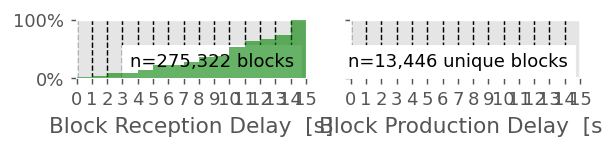

In [12]:
# display(EXP_multiple)
# EXP = EXP_multiple.value
# # display(EXP_drop)
# # EXP = EXP_drop.value
# print('Experiment datasets: '+','.join(EXP))

# Generate the dataframe
# df = create_df(EXP, 'block')
df = df_block
# df = df.get_param(df,'generic_params','block_period')
XMAX = 15

###############################################################
# Process the dataframe  
bins = range(0, XMAX+1, 1)

# Create figure
fig, ax = plt.subplots(1,2, sharey=True, figsize=flhh)

# Create plot
hist, bins = np.histogram(df['TELAPSED'], bins=bins)
ax[0].bar(bins[:-1]+(bins[1]-bins[0])/2, 
          np.cumsum(hist.astype(np.float32))/hist.sum(), 
          width =(bins[1]-bins[0]), 
          color ='green', 
          alpha = 0.6,
          zorder= 3)
# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax[0].grid(axis='x', linestyle='--', color='k',zorder=1) 
ax[0].text(XMAX-0.8,0.2,'n=%s blocks' % format(len(df), ',d'),ha='right',zorder=4)
t = ax[0].text(XMAX-0.8,0.2,'n=%s blocks' % format(len(df), ',d'),ha='right',color='white',zorder=2)
t.set_bbox(dict(facecolor='white', edgecolor='white'))
ax[0].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[0].set_ylim(ymin=0, ymax = 1)
ax[0].set_xticks(bins)
ax[0].set_xlim(xmin=bins[0], xmax = bins[-1])
ax[0].set_xlabel('Block Reception Delay  [s]')

###############################################################
# Process the dataframe  
df = df.drop_duplicates('HASH')
df = trim_chain(df, 10).sort_values('TIMESTAMP')
df['TPROD'] = df.groupby(['EXP', 'REP'])['TIMESTAMP'].diff(1)

# Create plot
hist, bins = np.histogram(df['TPROD'], bins=bins)
ax[1].bar(bins[:-1]+(bins[1]-bins[0])/2, 
          np.cumsum(hist.astype(np.float32))/hist.sum(), 
          width =(bins[1]-bins[0]), 
          color ='green', 
          alpha = 0.6,
          zorder=3)
# ax = df['TPROD'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax[1].grid(axis='x', linestyle='--', color='k',zorder=1) 
ax[1].text(XMAX-0.8,0.2,'n=%s unique blocks' % format(len(df), ',d'),ha='right',zorder=4)
t = ax[1].text(XMAX-0.8,0.2,'n=%s unique blocks' % format(len(df), ',d'),ha='right',color='white',zorder=2)
t.set_bbox(dict(facecolor='white', edgecolor='white'))
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax[1].set_ylim(ymin=0, ymax = 1)
ax[1].set_xticks(bins)
ax[1].set_xlim(xmin=bins[0], xmax = bins[-1])
ax[1].set_xlabel('Block Production Delay  [s]')

# Save plot
fig.tight_layout()
# plt.savefig("plots/multi/time_elapsed_both.png", bbox_inches='tight', dpi=600)
plt.show()

## Time elapsed between block production to reception

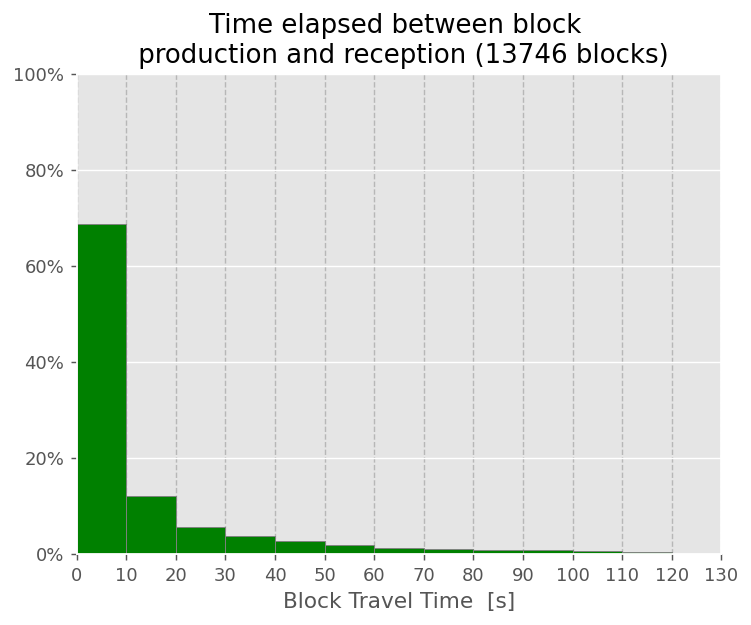

In [23]:

# # Generate the dataframe
df = df_block
df = df.get_param(df,'generic','block_period')

# Process the data  
bins = range(0, 140, 10)
XX = df.groupby('HASH')['TELAPSED'].agg('max').div(10)

# Create plot
ax = plt.axes()
hist, bins = np.histogram(XX, bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='gray')
# ax = df['TELAPSED'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax.grid(axis='x', linestyle='--', color='k', alpha=0.2) 
ax.set_title('Time elapsed between block \n production and reception (%s blocks)' % len(XX))

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 1)
# ax.set_ylabel('Percentage of blocks received within')

ax.set_xticks(bins)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Block Travel Time  [s]')

# Save plot
# plt.savefig("plots/experiment_"+EXP+"/time_elapsed_recept.png", bbox_inches='tight', dpi=600)
plt.show()

## Time elapsed between consecutive blocks

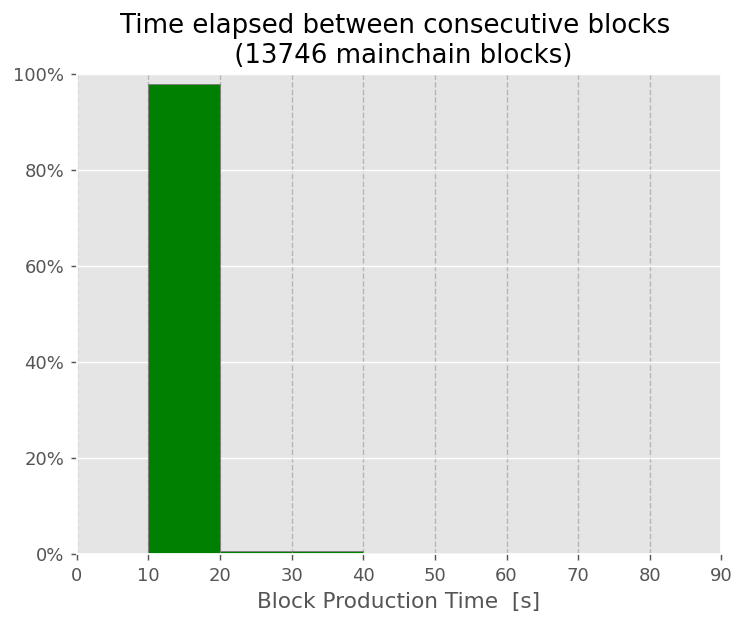

In [26]:
# # Generate the dataframe
df = df_block

# Process the dataframe  
df = df.get_param(df,'generic','block_period')
bins = range(0, 100, 10)

mainchains = get_mainchains(df)
df = df[df['HASH'].isin(mainchains)]
df = df.drop_duplicates('HASH')
df['TPROD'] = df.groupby(['EXP', 'REP'])['TIMESTAMP'].diff(1).div(10)

# Create plot
ax = plt.axes()
hist, bins = np.histogram(df['TPROD'], bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), color='green', edgecolor='gray')
# ax = df['TPROD'].plot.hist(color='green', bins=bins, xticks=xticks)

# Edit plot
ax.set_title('Time elapsed between consecutive blocks \n (%s mainchain blocks)' % len(df))
ax.grid(axis='x', linestyle='--', color='k', alpha=0.2) 

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 1)
# ax.set_ylabel('Percentage of blocks produced within')

ax.set_xticks(bins)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Block Production Time  [s]')

# Save plot
# plt.savefig("plots/experiment_"+EXP+"/time_elapsed_prod.png", dpi=600)
plt.show()

## Check how many blocks were produced

In [27]:
df = df_block

# Process the dataframe  
mainchains = get_mainchains(df)
df = df[df['HASH'].isin(mainchains)]
df = df.drop_duplicates('HASH')

display(df.groupby(['EXP', 'CFG', 'REP'], as_index=False).agg({'BLOCK':'max'}))

,EXP,CFG,REP,BLOCK
0,1patch,unitdemand,001,429
1,1patch,unitdemand,002,404
2,1patch,unitdemand,003,443
3,1patch,unitdemand,004,465
4,1patch,unitdemand,005,448
5,1patch,unitdemand,006,486
6,1patch,unitdemand,007,474
7,1patch,unitdemand,008,426
8,1patch,unitdemand,009,495
9,1patch,unitdemand,010,426


## Reward V Time (plot)

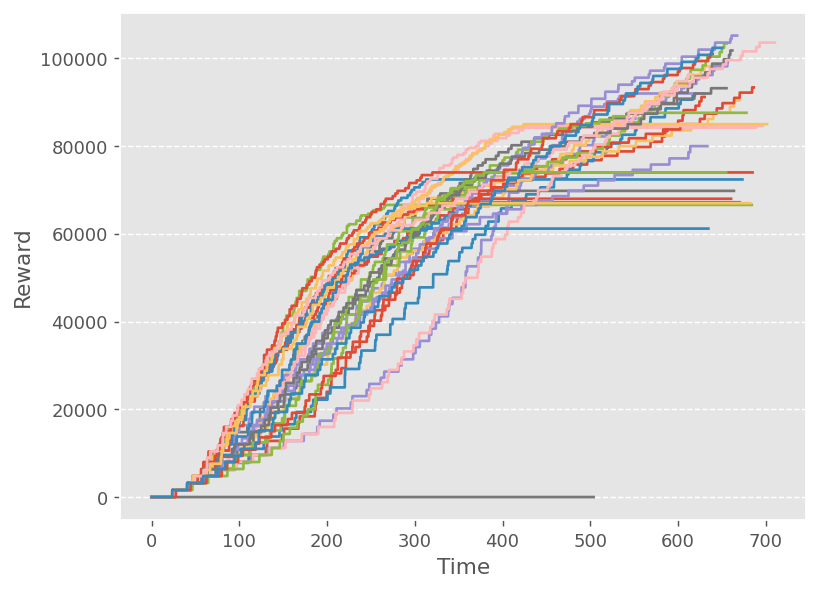

In [28]:
# Generate the dataframe
df = df_loop

# Plot options
XX = 'TIME'
YY = 'VALUE'
BP = 'Robots'
yl = 'Reward'
xl = 'Time'
fs = xm(2)*flwidth

# Process the data 
df = df.set_index(XX).groupby(EXP_CFG_REP)

# Create plot
ax = plt.axes()
df[YY].plot(ax=ax)

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = df[YY].max()*1.1)
    
plt.gcf().tight_layout()
# ax.legend()
# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Revenue (boxplot)

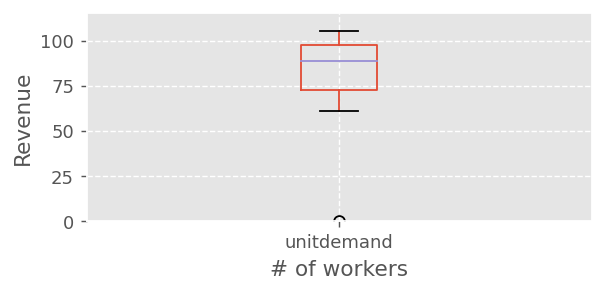

In [29]:
# Generate the dataframe
df = df_loop
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
# df = get_param_df(df, 'experiment', 'MAXWORKERS', alias = 'limit')
# df = get_param_df(df, 'experiment', 'EPSILON', alias = 'epsilon')

# Plot options
XX = 'CFG'
YY = 'VALUE'
BP = 'EXP'
yl = 'Revenue'
xl = '# of workers'
fs = flwidth

# Process the data 
df[YY] = df[YY].div(1000)
df = df.groupby([]+EXP_CFG_REP, as_index=False).agg({YY:'max'})

# Create plot
bp = df.groupby(BP).boxplot(column=[YY], by = XX, sharex=True, figsize=fs, layout=(1,1))

# Edit plot 
plt.suptitle('')
# for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(True, linestyle = '--')
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel(xl)
for axi in bp: axi.set_ylabel(yl)
for axi in bp: axi.set_title('') 
for axi in bp: axi.set_ylim(ymin=0, ymax = df[YY].max()*1.1)
    
plt.gcf().tight_layout()
# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

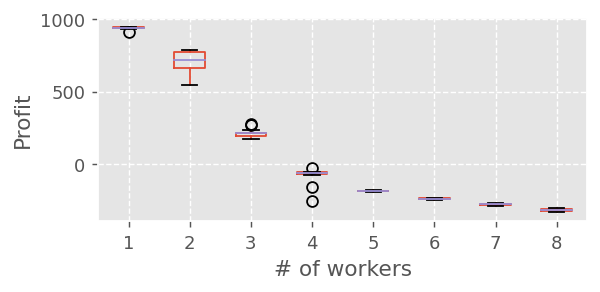

In [9]:
# Generate the dataframe
df = df_firm
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')

# Plot options
XX = 'CFG'
YY = 'PROFIT'
BP = 'EXP'
yl = 'Profit'
xl = '# of workers'
fs = flwidth

# Process the data 
df = df.groupby([]+EXP_CFG_REP, as_index=False).agg({YY:'mean'})

# Create plot
bp = df.groupby(BP).boxplot(column=[YY], by = XX, sharex=True, figsize=fs, layout=(1,1))

# Edit plot 
plt.suptitle('')
# for axi in bp:axi.xaxis.set_minor_locator(ticker.NullLocator())
for axi in bp: axi.xaxis.grid(True, linestyle = '--')
for axi in bp: axi.yaxis.grid(True, linestyle = '--')
for axi in bp: axi.set_xlabel(xl)
for axi in bp: axi.set_ylabel(yl)
for axi in bp: axi.set_title('') 
# for axi in bp: axi.set_ylim(ymin=0, ymax = df[YY].max()*1.1)
    
plt.gcf().tight_layout()
# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Smart Contract (plot)

In [ ]:
# Generate the dataframe
df = df_sc
# df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
# display(df)

# Plot options
XX = 'BLOCK'
YY = 'WCOUNT'
yl = 'Number of Workers'
xl = 'Block'
fs = double

# Process the data
df["XY"] = df["X"].astype(str)
+ df["Y"].astype(str)
df = df.drop_duplicates(['HASH','XY']).sort_values('BLOCK').reset_index()

main_leaf = df.iloc[-1]['HASH']
main_df = get_mainchain_df(df, main_leaf).reset_index()
df = df[df['HASH'].isin(main_df['HASH'])]

dfp = df[[YY, 'BLOCK','QLTY']].pivot(columns='QLTY', values=YY).fillna(0).astype(int)
dfp['BLOCK'] = df['BLOCK']
dfp = dfp.set_index('BLOCK')

# Create plot
ax = plt.axes()
dfp.groupby('BLOCK').agg('sum').plot.area(color=dfp.columns.values,linestyle='None', legend='None', ax=ax)

# Edit plot 
plt.suptitle('')
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')

ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('')   
ax.get_legend().remove()

# Save plot
plt.gcf().tight_layout()
# plt.savefig("plots/experiment_"+EXP+"/storage_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Firm (plot)

In [34]:
display(df_sc)

,ID,TIME,TIMESTAMP,BLOCK,HASH,PHASH,BALANCE,TX_COUNT,X,Y,...,ATC,price,robots,TQ,AATC,AP,EXP,CFG,REP,CONTROLLER
0,1,1.729161e+09,0,0,849f88fe514e3c617eea1c11b175316038208403cc67ad...,0,0.0,0,1.12,1.12,...,[],1.00,[],0,0.0,0.0,1patch,unitdemand,001,unitdemand
1,1,1.729161e+09,100,1,f307aa4a98b7e6043368c7d9039c12498bae77438d41ae...,849f88fe514e3c617eea1c11b175316038208403cc67ad...,0.0,20,1.12,1.12,...,[],1.00,[],0,0.0,0.0,1patch,unitdemand,001,unitdemand
2,1,1.729161e+09,200,2,d8e3348b681c6e8e98f9d9e3827e8212b7bf3fc2cbf83a...,f307aa4a98b7e6043368c7d9039c12498bae77438d41ae...,0.0,20,1.12,1.12,...,[],1.00,[],0,0.0,0.0,1patch,unitdemand,001,unitdemand
3,1,1.729161e+09,300,3,1f6f63336f9cb98906df0ff9b8fdf64bae3e700e6ae5af...,d8e3348b681c6e8e98f9d9e3827e8212b7bf3fc2cbf83a...,0.0,20,1.12,1.12,...,[],1.00,[],0,0.0,0.0,1patch,unitdemand,001,unitdemand
4,1,1.729161e+09,400,4,0e0b2916c7958600d53cda851c1f83acdc4cca0216655c...,1f6f63336f9cb98906df0ff9b8fdf64bae3e700e6ae5af...,0.0,20,1.12,1.12,...,[],1.00,[],0,0.0,0.0,1patch,unitdemand,001,unitdemand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275317,9,1.729180e+09,49381,436,5a0e61a4cf0633177deff998d6b2964ad587b525bc5f24...,518cad9a1c56f8e01152e936cb0b002f5f9da6901d57ca...,0.0,121,1.12,1.12,...,"[142.3,141.6,145.1,141.6,141.6,146.6,141.6,141...",0.54,"['2','2','2','2','16','2','16','2','16','10','...",494,132.5,-24.5,1patch,unitdemand,030,unitdemand
275318,9,1.729180e+09,49481,437,49cc292d2c3be9c90b25a835f137e07ba57535bbace226...,5a0e61a4cf0633177deff998d6b2964ad587b525bc5f24...,0.0,121,1.12,1.12,...,"[142.3,141.6,145.1,141.6,141.6,146.6,141.6,141...",0.54,"['2','2','2','2','16','2','16','2','16','10','...",494,132.5,-24.5,1patch,unitdemand,030,unitdemand
275319,9,1.729180e+09,49581,438,805a2a35a55f8dc86789a64549f0b6c2ae3fdf31287263...,49cc292d2c3be9c90b25a835f137e07ba57535bbace226...,0.0,121,1.12,1.12,...,"[142.3,141.6,145.1,141.6,141.6,146.6,141.6,141...",0.54,"['2','2','2','2','16','2','16','2','16','10','...",494,132.5,-24.5,1patch,unitdemand,030,unitdemand
275320,9,1.729180e+09,49681,439,563b887984d2baa4b1422db47d091c8e6bf1858b01ccc1...,805a2a35a55f8dc86789a64549f0b6c2ae3fdf31287263...,0.0,121,1.12,1.12,...,"[142.3,141.6,145.1,141.6,141.6,146.6,141.6,141...",0.54,"['2','2','2','2','16','2','16','2','16','10','...",494,132.5,-24.5,1patch,unitdemand,030,unitdemand


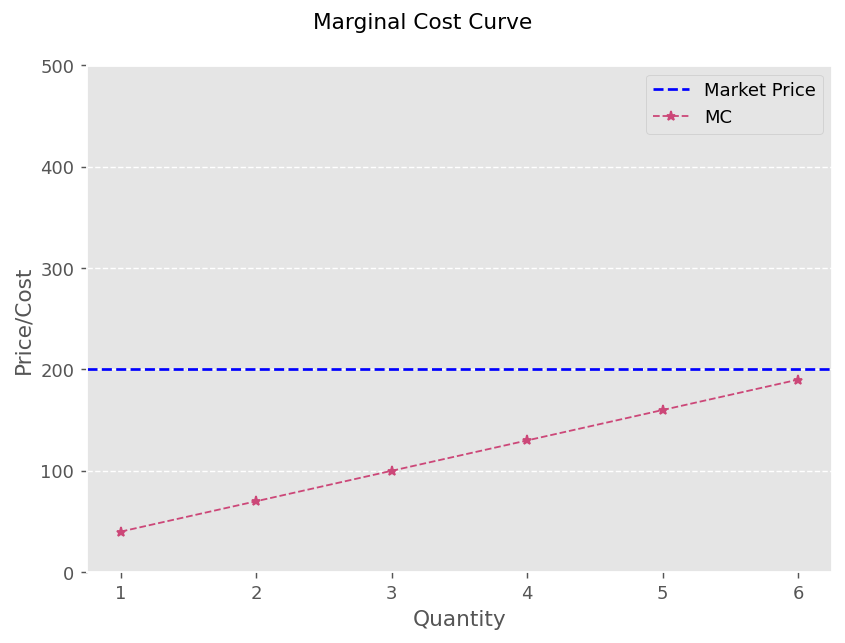

In [30]:
# Generate the dataframe
df = df_firm
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'Reward')

df['C']      = df.apply(lambda row: eval(row['C'].replace(',', ', ')), axis=1)
df['MC']     = df.apply(lambda row: eval(row['MC'].replace(',', ', ')), axis=1)
df['Q']      = df['Q'].astype(int)

del df['TIME']
df['MC_idx'] = df['MC'].apply(lambda x: list(range(1, len(x) + 1)))

# Plot options
XX = 'CFG'
YY = 'MC'
yl = 'Price/Cost'
xl = 'Quantity'
fs = double

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

palette = sns.color_palette('plasma', len(df[EXP_CFG+['QLTY']].drop_duplicates()))

for i, (qlty, group) in enumerate(df.groupby('QLTY')):
    plt.axhline(y = group['UTIL'].mean(), color = qlty, linestyle = '--', label="Market Price")
    label_mc, label_atc  = "Marginal Cost", "Average Total Cost"
    

df_mc = df.explode(['MC', 'MC_idx']).reset_index(drop=True)
df_mc = df_mc.groupby(EXP_CFG+['MC_idx','QLTY'])[YY].mean()
df_mc = df_mc.reset_index().set_index('MC_idx')

# Loop through the unique EXP_CFG values and plot each one
for i, (exp_cfg_val, group) in enumerate(df_mc.groupby(EXP_CFG+['QLTY'])):
    group.plot(
        ax=ax, linestyle='--', linewidth=1, marker='*', markersize=5,
        label=f"{label_mc}: {exp_cfg_val[1]} worker", color=palette[i])

# Edit plot 
plt.suptitle('Marginal Cost Curve')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
ax.set_ylim(ymin=0, ymax = 500)
# ax.set_xlim(xmin=0, xmax = 20)
ax.legend()

plt.gcf().tight_layout()

# # plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
# plt.show()

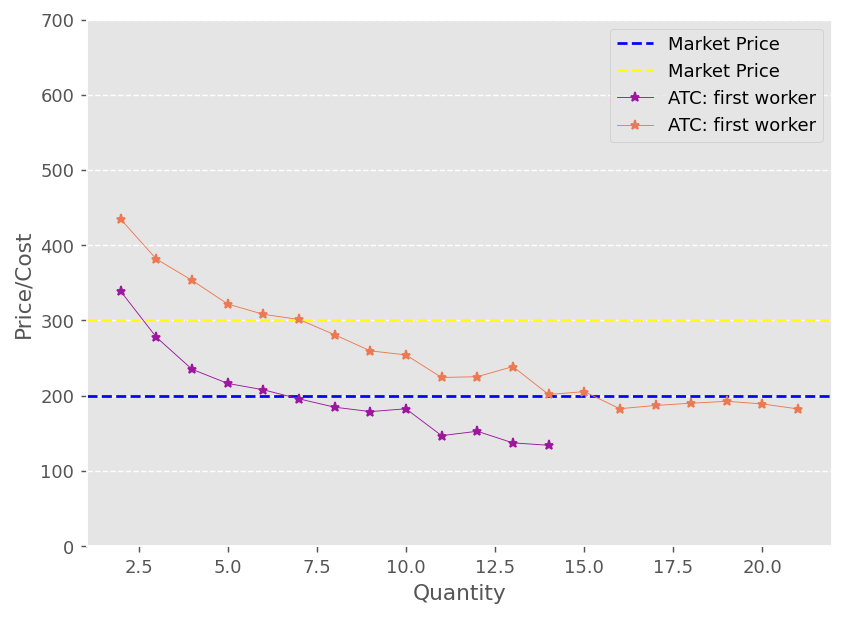

In [18]:
# Generate the dataframe
df = df_firm
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'Reward')


df['C']      = df.apply(lambda row: eval(row['C'].replace(',', ', ')), axis=1)
df['MC']     = df.apply(lambda row: eval(row['MC'].replace(',', ', ')), axis=1)
df['Q']      = df['Q'].astype(int)
df['TIME']   = df['TSTART']

# Plot options
XX = 'CFG'
YY = 'ATC'
yl = 'Price/Cost'
xl = 'Quantity'
fs = double

# df = df.query('QLTY=="yellow"')   
# df = df.query('Q>16')   
# df['MCm'] = df.apply(lambda row: max(row['MC']), axis=1)
# df = df.query('REP=="010"')
# df = df.query('CFG=="7"')
# display(df[['Q','MCm', 'ATC']])
# display(df)
# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

palette = sns.color_palette('plasma', len(df[EXP_CFG+['QLTY']].drop_duplicates()))

for i, (qlty, group) in enumerate(df.groupby('QLTY')):
    plt.axhline(y = group['UTIL'].mean(), color = qlty, linestyle = '--', label="Market Price")
    label_mc, label_atc  = "Marginal Cost", "Average Total Cost"

# ## Actual Drops
# for i, (exp_cfg_val, group) in enumerate(df.groupby(EXP_CFG)):
#     group.set_index('Q').sort_index()['ATC'].plot(
#         ax=ax, linestyle='', linewidth=0.5, marker='*', markersize=5,
#         label="_nolegend_", color=palette[i])

## Average Total Cost Mean
df_ATC = df.groupby(EXP_CFG+['Q','QLTY'])[YY].mean()

# Loop through the unique EXP_CFG values and plot each one
for i, (exp_cfg_val, group) in enumerate(df.groupby(EXP_CFG+['QLTY'])):
    group_ATC = group.groupby('Q')[YY].mean()  # Group by Q and calculate mean ATC
    group_ATC.plot(
        ax=ax, linestyle='-', linewidth=0.5, marker='*', markersize=5,
        label=f"{YY}: {exp_cfg_val[1]} worker", color=palette[i])

# dfa, i = pd.DataFrame(), 0

# ## Marginal Cost
# for g,d in df.explode('MC').groupby('TIME'):
#     d.reset_index(inplace=True)
#     d.index +=2
#     (d['MC']).plot(ax=ax, linestyle = '', linewidth = '0.5',marker='.', markersize='2', color = 'k', label=label_mc)
#     label_mc = "_nolegend_"
#     i+=1
#     dfa[str(i)] =d['MC']
    
# ## Marginal Cost Mean
# dfa_mean = dfa.mean(axis=1)  
# dfa_mean.plot(ax=ax, linestyle = '--', linewidth = '2',marker='', markersize='2.5', color = 'k', label="MC (mean)")

    
# # for g,d in df.explode('C').groupby('TIME'):
# #     d.reset_index(inplace=True)
# #     d.index += 1
# #     (d['C']+d['FC']).plot(ax=ax, linestyle = '-', linewidth = '0.5', marker='*', markersize='2.5', color = 'g')
    

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
ax.set_ylim(ymin=0, ymax = 700)
# ax.set_xlim(xmin=0, xmax = 20)
ax.legend()

plt.gcf().tight_layout()
# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## SC (Balances)

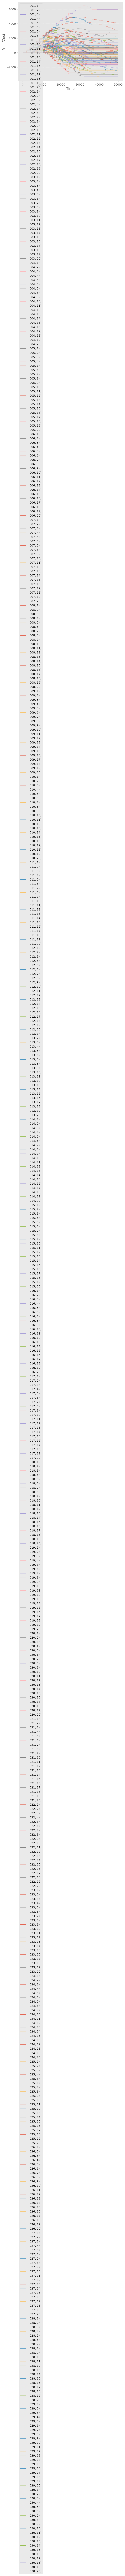

In [35]:
# Generate the dataframe
df = df_sc
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'Reward')

# Plot options
XX = 'TIMESTAMP'
YY = 'BALANCE'
yl = 'Price/Cost'
xl = 'Time'
fs = double

# Corrections to dataframe
# df['BALANCE'] = df['QTTY']
df = df.set_index(XX)
# df['Reward'] = df.apply(lambda row: eval(row['Reward'])['blue'], axis=1)
# display(df)


# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

## Balance
df.groupby(['REP','ID'])[YY].plot(
    ax=ax, linestyle = '-', linewidth = '0.5', markersize='5')

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 30)
# ax.set_xlim(xmin=0, xmax = 20)
ax.legend()

plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Epoch (Unit Cost over Time)

Text(0.5, 1.0, '')

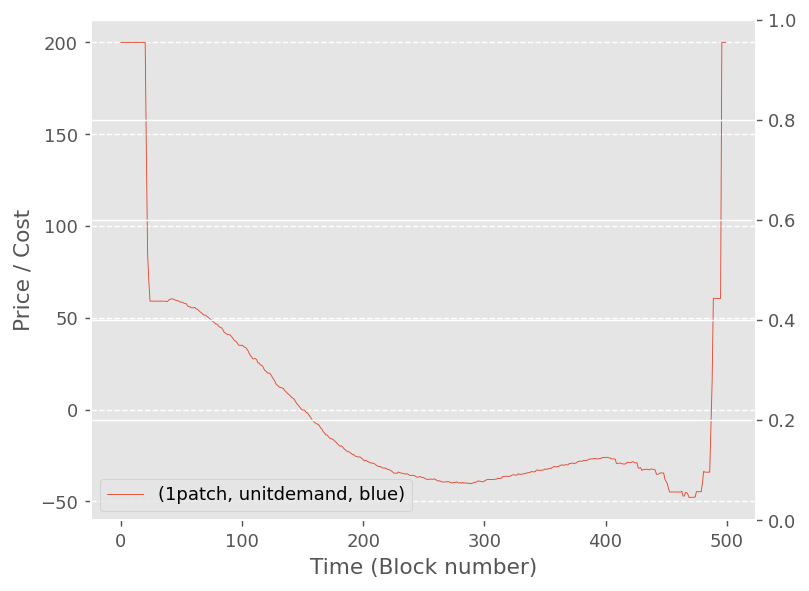

In [40]:
# Generate the dataframe
df = df_sc
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'utility')

# Plot options
XX = 'start'
YY = 'profit'
yl = 'Price / Cost'
xl = 'Time (Block number)'
fs = double
labels = ["Market Price", "Marginal Cost", "Average Total Cost", "Number of Workers"]

# Corrections to dataframe
df = df.drop_duplicates(['HASH','QLTY'])
df['UTIL']   = df.apply(lambda row: eval(row['utility'])[row['QLTY']], axis=1)
df['price']  = df['price']*df['UTIL']
df['profit'] = df['price']-df['AATC']

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()
palette = sns.color_palette('plasma', len(df[EXP_CFG+['QLTY']].drop_duplicates()))

# Market price 
# for i, (qlty, group) in enumerate(df.groupby('QLTY')):
#     plt.axhline(y = group['UTIL'].mean(), color = qlty, linestyle = '--', label="Market Price")
#     label_mc, label_atc  = "Marginal Cost", "Average Total Cost"

# display(df['profit'])

## ATC 
# df = df.query("REP=='002'")
# df.query("REP=='002'").set_index('BLOCK').groupby(EXP_CFG_REP)[YY].plot(
#     ax=ax, linestyle = '-', linewidth = '0.5', color = 'r', label=labels[1])

avg_AATC = df.groupby(['EXP','CFG','BLOCK','QLTY'])[YY].mean().reset_index()
avg_AATC.set_index('BLOCK').groupby(EXP_CFG+['QLTY'])[YY].plot(
    ax=ax, linestyle='-', linewidth=0.5)


## Workers
# ax2 = ax.twinx() 
# # df.query("REP=='002'").set_index('BLOCK').groupby(EXP_CFG_REP)['TOTW'].plot(
# #     ax=ax2, drawstyle="steps-post", linestyle = '-', marker='.', linewidth = '0.5', color = 'k', label=labels[3])

# avg_TOTW = df.groupby(['EXP','CFG','BLOCK'])['TOTW'].mean().reset_index()
# avg_TOTW.set_index('BLOCK')['TOTW'].plot(
#     ax=ax2, linestyle='-', linewidth=0.5, color='k', label='Average')

## Workers
ax2 = ax.twinx() 
# df.query("REP=='002'").set_index('BLOCK').groupby(EXP_CFG_REP)['TOTW'].plot(
#     ax=ax2, drawstyle="steps-post", linestyle = '-', marker='.', linewidth = '0.5', color = 'k', label=labels[3])

# avg_TQ = df.groupby(['EXP','CFG','BLOCK'])['TOTW'].mean().reset_index()
# avg_TQ.set_index('BLOCK')['TOTW'].plot(
#     ax=ax2, linestyle='-', linewidth=0.5, color='k', label='Average')

# # display(df)
# Edit plot 
ax.legend()
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 30)


## Epoch (Total Profit)

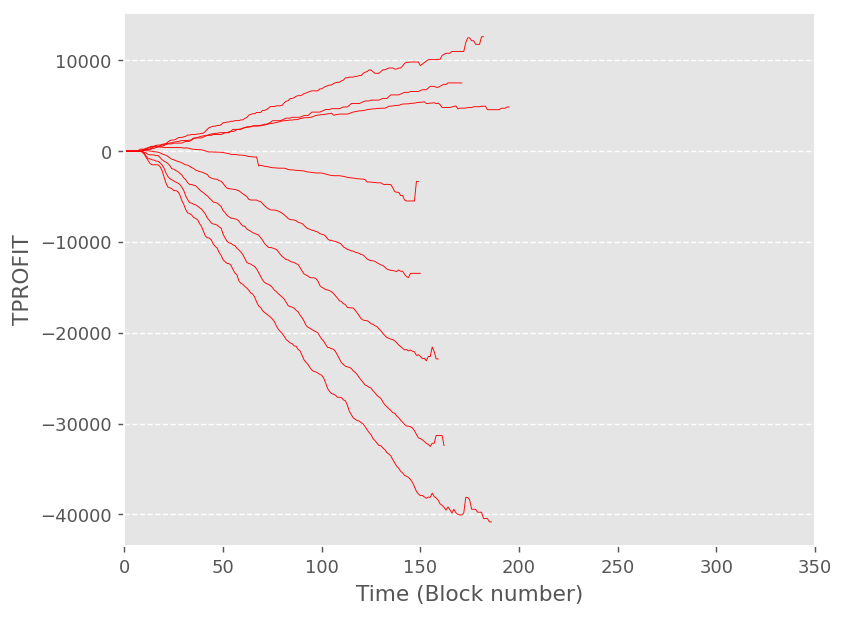

In [81]:
df = df_sc
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'utility')

# Corrections to dataframe
df = df.drop_duplicates(['HASH'])
# df = df.query('REP=="001"')
# df['utility'] = df.apply(lambda row: eval(row['utility'])['blue'], axis=1)
df['drops'] = df.apply(lambda row: len(eval(row['Q'].replace(',', ', '))), axis=1)
# df['TC'] = df.apply(lambda row: eval(row['TC'].replace(',', ', ')), axis=1)
# df['ATC'] = df.apply(lambda row: eval(row['ATC'].replace(',', ', ')), axis=1)
# df['AATC'] = df.apply(lambda row: sum([a*b for a,b in zip(row['Q'],row['ATC'])])/sum(row['Q']), axis=1)
# df['WORKERS'] = df.apply(lambda row: len(row['Q']), axis=1)
# df['MPRICE'] = df.apply(lambda row: row['price']*row['utility'], axis=1)
# df['DURATION'] = df['start'].diff()

# df['TQ'] = df.apply(lambda row: sum(row['Q']), axis=1)
# df['TQPERROBO'] = df.apply(lambda row: sum(row['Q']), axis=1)
# df['TQTIME'] = df.apply(lambda row: row['TQ']/row['DURATION']/2, axis=1)
# df['TREVENUE'] = df.apply(lambda row: sum([q*row['price']*row['utility'] for q in row['Q']]), axis=1)
# df['TCOST'] = df.apply(lambda row: sum(row['TC']), axis=1)
df['TPROFIT'] = df.apply(lambda row: (row['TQ']*row['AP']), axis=1)
df['TPROFITPERROBOT'] = df.apply(lambda row: row['TPROFIT']/row['TOTW'], axis=1)

# df['TPROFITSCALED'] = df.apply(lambda row: (row['TREVENUE']-row['TCOST'])/100, axis=1)
# df['TPROFITTIME'] = df.apply(lambda row: row['TPROFIT']/row['DURATION'], axis=1)

df['new_drop'] = (df['drops'] != df['drops'].shift(1)).astype(int)
df['new_drop'] = df['new_drop'] * df['TPROFIT']
df['TPROFITCUMSUM'] =  df.groupby('REP')['new_drop'].transform(pd.Series.cumsum)

# print(df.query('NEW!=0')['NEW'])
# display(df[['drops','TPROFIT','new_drop']])

# Plot options
XX = 'BLOCK'
YY = 'TPROFIT'
yl = YY
xl = 'Time (Block number)'
fs = double
labels = ["Market Price", "Marginal Cost", "Average Total Cost", "Number of Workers"]

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

# df.set_index(XX).groupby(EXP_CFG_REP)[YY].plot(
#     ax=ax, linestyle = '-', marker='.', linewidth = '0.5', color = 'r', label=labels[1])

avg_YY = df.groupby(['EXP','CFG','BLOCK'])[YY].mean().reset_index()
avg_YY.set_index('BLOCK').groupby(EXP_CFG)[YY].plot(
    ax=ax, linestyle='-', linewidth=0.5, color='r', label='Average')


# ## Workers
# ax2 = ax.twinx() 
# df.set_index(XX).groupby(['CFG','REP'])['WORKERS'].plot(ax=ax2, linestyle = '-', marker='.', linewidth = '0.5', color = 'k', label=labels[3])

# display(df)
# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)

ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 30)
ax.set_xlim(xmin=0, xmax = 350)
# ax.legend()
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)

plt.show()

## Epoch (Profit Boxplot)

In [ ]:
# Generate the dataframe
df = load_df('epoch')
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'utility')

# Corrections to dataframe
df = df.drop_duplicates(subset=['NUMBER','BSTART', 'Q', 'TC'])
df['CFG'] = df['CFG'].astype('int')

if 'BSTART' in df and not df['BSTART'].isnull().values.any():
    df['start'] = df['BSTART']
df['utility'] = df.apply(lambda row: eval(row['utility'])['blue'], axis=1)
df['Q'] = df.apply(lambda row: eval(row['Q'].replace(',', ', ')), axis=1)
df['TC'] = df.apply(lambda row: eval(row['TC'].replace(',', ', ')), axis=1)
df['ATC'] = df.apply(lambda row: eval(row['ATC'].replace(',', ', ')), axis=1)
df['AATC'] = df.apply(lambda row: sum([a*b for a,b in zip(row['Q'],row['ATC'])])/sum(row['Q']), axis=1)
df['WORKERS'] = df.apply(lambda row: len(row['Q']), axis=1)
df['MPRICE'] = df.apply(lambda row: row['price']*row['utility'], axis=1)
df['DURATION'] = df['start'].diff()

df['TQ'] = df.apply(lambda row: sum(row['Q']), axis=1)
df['TQTIME'] = df.apply(lambda row: row['TQ']/row['DURATION']/2, axis=1)
df['TREVENUE'] = df.apply(lambda row: sum([q*row['price']*row['utility'] for q in row['Q']]), axis=1)
df['TCOST'] = df.apply(lambda row: sum(row['TC']), axis=1)
df['TPROFIT'] = df.apply(lambda row: (row['TREVENUE']-row['TCOST']), axis=1)
df['TPROFITPERROBOT'] = df.apply(lambda row: (row['TREVENUE']-row['TCOST'])/row['WORKERS'], axis=1)
df['TPROFITCUMSUM'] =  df.groupby(['CFG','REP'])['TPROFIT'].transform(pd.Series.cumsum)
df['TPROFITSCALED'] = df.apply(lambda row: (row['TREVENUE']-row['TCOST'])/100, axis=1)
df['TPROFITTIME'] = df.apply(lambda row: row['TPROFIT']/row['DURATION'], axis=1)

# Plot options
# display(df[['ATC', 'AATC']])
XX = 'start'
YY = 'TQ'
BP = 'REP'
yl = YY
xl = 'Time (Block number)'
fs = double
labels = ["Market Price", "Marginal Cost", "Average Total Cost", "Number of Workers"]

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()


df = df.groupby(['CFG', 'REP'], as_index=False).agg({YY:'sum', 'TCOST':'sum'})
df['ATCOST'] = df['TCOST']/df[YY]
display(df)

# Create plot
bp = df.groupby(BP).boxplot(column=[YY], by = XX, sharex=True, figsize=fs, layout=(1,1))


# df.set_index(XX).groupby('REP')[YY].plot(ax=ax, linestyle = '-', marker='.', linewidth = '0.5', color = 'r', label=labels[1])

# ## Workers
# ax2 = ax.twinx() 
# df.set_index(XX).groupby('REP')['WORKERS'].plot(ax=ax2, linestyle = '-', marker='.', linewidth = '0.5', color = 'k', label=labels[3])

# display(df)
# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
# ax.xaxis.set_ticks(d.index-1)
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)

ax.set_title('') 
# ax.set_ylim(ymin=0, ymax = 30)
# ax.set_xlim(xmin=0, xmax = 20)
# ax.legend()
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Patches (Quantity)

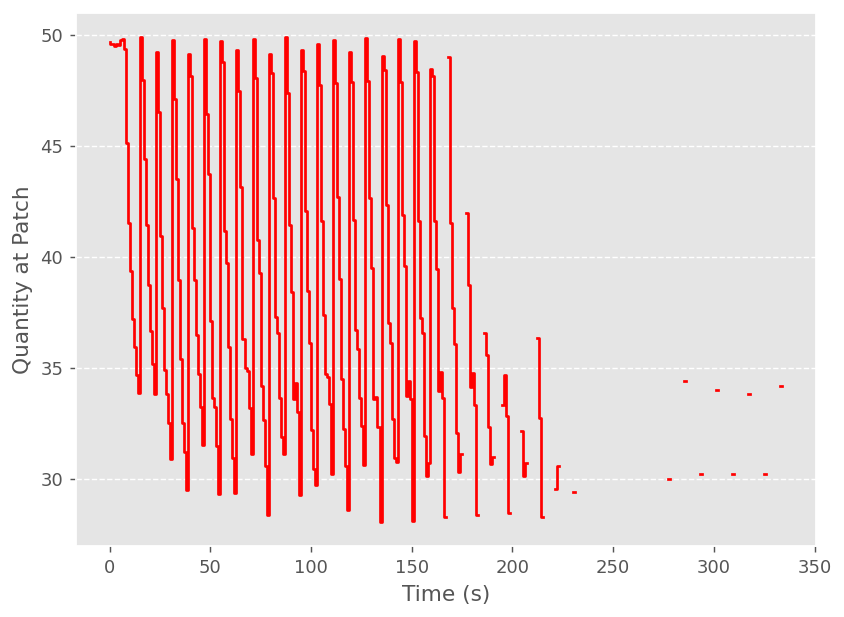

In [82]:
# Generate the dataframe
# df = load_df('patches')
df = df_patches
df = get_param_df(df, 'generic', 'num_robots', alias = 'Robots')
df = get_param_df(df, 'patches', 'utility', alias = 'utility')

# Plot options
XX = 'TIME'
YY = 'QTTY'
yl = 'Quantity at Patch'
xl = 'Time (s)'
fs = double
labels = ["Market Price", "Marginal Cost", "Average Total Cost", "Number of Workers"]

# df['QTTY'] = df.apply(lambda row: {x.split(':')[0]: x.split(':')[1] for x in row['JSON'].split(',')}['quantity'], axis=1)
df['QTTY'] = df.apply(lambda row: eval(row['JSON'])['quantity'], axis=1)

df = df.set_index(XX)  

# Create plot
fig, ax = plt.figure(figsize=fs), plt.axes()

# Quantity at patch
time_window = 10
df['TIME_BIN'] = pd.cut(df.index, bins=pd.interval_range(start=df.index.min(), 
                                                          end=df.index.max(), 
                                                          freq=time_window))

avg_YY = df.groupby(['TIME_BIN', 'EXP', 'CFG'])[YY].mean().reset_index()

avg_YY[YY].plot(
    ax=ax, drawstyle="steps", linestyle = '-', color = 'r', label=labels[1])

# Edit plot 
plt.suptitle('')
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle = '--')
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_title('') 
# ax.legend()
plt.gcf().tight_layout()

# plt.savefig("plots/experiment_"+EXP+"/value_bp_%s_%s.png" % (XX,YY), bbox_inches='tight', dpi=600)
plt.show()

## Ticks per second (histogram)

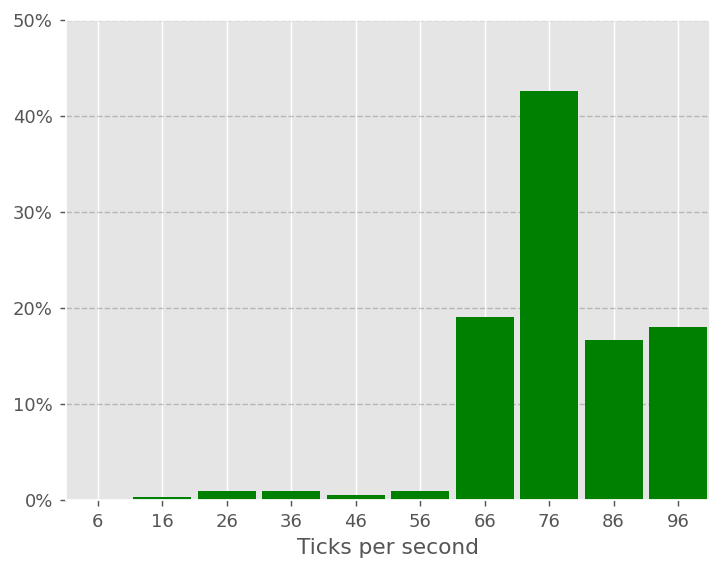

In [41]:
# display(EXP_drop)
# EXP = EXP_drop.value

# Generate the dataframe
df = df_sim

# Process the dataframe 
step = 10
bins = np.arange(df['TPS'].min(), df['TPS'].max(), step)-step/2
xticks = np.arange(df['TPS'].min(), df['TPS'].max()+step, step)

# Create plot
ax = plt.axes()
hist, bins = np.histogram(df['TPS'], bins=bins)
ax.bar(bins[:-1]+(bins[1]-bins[0])/2, hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0])*0.9, color='green')

# Edit plot
ax.grid(axis='y', linestyle='--', color='k', alpha=0.2, zorder=0) 

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.set_ylim(ymin=0, ymax = 0.5)
ax.set_xticks(xticks)
ax.set_xlim(xmin=bins[0], xmax = bins[-1])
ax.set_xlabel('Ticks per second')

# Save plot
# plt.savefig("plots/experiment_"+EXP+"/ticks_per_second.png", bbox_inches='tight')
plt.show()

## Blockchain Visualizer (graph)

In [84]:
# Select which experiment to plot the whole blockchain
df = df_block
df = df.query("REP=='001'")

df = df.drop_duplicates('HASH').sort_values('BLOCK').reset_index()
display(df)

# Process data
genesis = df['PHASH'].iloc[0]
main_leaf = df[df['TDIFF'] == df['TDIFF'].max()]['HASH'].iloc[0]

# Iterate from main_leaf to genesis -> mainchain
df_mainchain = get_mainchain_df(df, main_leaf)

# Block hashes not in the mainchain -> forks
df_forks = df.query("HASH not in @df_mainchain['HASH']")

# Block hashes which are in forks, but are not parents -> leafs
df_leafs = df_forks.query('HASH not in PHASH')

# Block hashes which are in forks, are parents but not children -> roots
df_roots = df_forks.query('PHASH not in HASH')


,index,ID,TIME,TELAPSED,TIMESTAMP,BLOCK,HASH,PHASH,DIFF,TDIFF,SIZE,TXS,UNC,PENDING,QUEUED,EXP,CFG,REP,CONTROLLER
0,0,1,1.727856e+09,19999,0,0,849f88fe514e3c617eea1c11b175316038208403cc67ad...,0,0,0,0.046875,0,0,NaN,NaN,varyworkers,1,001,1
1,63929,1,1.727860e+09,19899,100,1,2aa2b5de6fc773b47bcfc6633d510c60ff81047eea3e8d...,849f88fe514e3c617eea1c11b175316038208403cc67ad...,2,2,0.046875,23,0,NaN,NaN,varyworkers,3,001,3
2,95533,1,1.727862e+09,19899,100,1,140a24ae733f559f0659bd9c39517763fc1a842f8a9bfd...,849f88fe514e3c617eea1c11b175316038208403cc67ad...,2,2,0.046875,24,0,NaN,NaN,varyworkers,4,001,4
3,122792,1,1.727864e+09,19899,100,1,06286fed333a84f05fca5cfbfdc3c49c1900c98e3cd3a6...,849f88fe514e3c617eea1c11b175316038208403cc67ad...,2,2,0.046875,25,0,NaN,NaN,varyworkers,5,001,5
4,181402,1,1.727869e+09,19899,100,1,472110c477b913b2b1ef0b74caef2310e6c905b067be26...,849f88fe514e3c617eea1c11b175316038208403cc67ad...,2,2,0.046875,27,0,NaN,NaN,varyworkers,7,001,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,153230,20,1.727867e+09,5,19994,159,e2135de6830b3cfc12e835160081420303dac2536518e7...,b4ff634f6fa3e36d661dfb802d6d78e5ea39e53b842399...,2,318,0.046875,0,0,NaN,NaN,varyworkers,6,001,6
1188,160,1,1.727856e+09,382,19617,160,d2a53fc2e9665af4d0eb17075cee5adbc5f7d2b2caa93a...,e8d18acc8a7f885aee02d832ec107dbfc9af3f8e39bd68...,2,320,0.046875,0,0,NaN,NaN,varyworkers,1,001,1
1189,161,1,1.727856e+09,282,19717,161,85e568d93c58de7984cc063371e21abced2b3190192e83...,d2a53fc2e9665af4d0eb17075cee5adbc5f7d2b2caa93a...,2,322,0.046875,0,0,NaN,NaN,varyworkers,1,001,1
1190,162,1,1.727856e+09,182,19817,162,bc5dc22463db88c3ac8aab7ff678951b1acb8a5a6364ac...,85e568d93c58de7984cc063371e21abced2b3190192e83...,2,324,0.046875,0,0,NaN,NaN,varyworkers,1,001,1


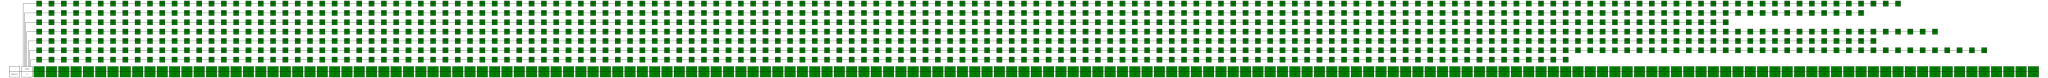

In [85]:
TRIM_FORKS = 0

# fork_paths = [[y] for y in df_leafs['HASH']]
# df_roots.apply(lambda row : fork_paths.extend(nx.all_simple_paths(forks_nx, row['HASH'], list(df_leafs['HASH']))), axis = 1)
# fork_paths_longer_than = paths_longer_than(fork_paths, MIN_FORK_LENGTH)
# nodes_in_forks_longer_than = nodes_in_paths(fork_paths_longer_than)
# df_trimmed = df.query('HASH in @nodes_in_forks_longer_than or HASH in @df_mainchain['HASH']')

df_trimmed = trim_chain(df, TRIM_FORKS)
# display(df_trimmed)

bc = create_digraph(df)
bc_trimmed = create_digraph(df_trimmed)

# Do something cool? Idk, for example mainchain in blue or make it bigger
df_trimmed.query("HASH in @df_mainchain['HASH']").apply(lambda row : bc_trimmed.node(row['HASH'], height='0.7', width='0.7'), axis = 1)
bc_trimmed.node(genesis, height='0.7', width='0.7')

# Do something cool? Idk, for example color blocks sealed by prefered sealer in green. 
df_trimmed.query('DIFF==2').apply(lambda row : bc_trimmed.node(row['HASH'], style='filled', fillcolor='green'), axis = 1)

# Do something cool? Idk, for example try to make mainchain at same level
df_trimmed.query("HASH in @df_mainchain['HASH']").apply(lambda row : bc_trimmed.node(row['HASH'], group='main'), axis = 1)
bc_trimmed.node(genesis, group='main')


# # Do something cool? Idk, make all black for mini-plot
# df_trimmed.apply(lambda row : bc_trimmed.node(row['HASH'], style='filled', fillcolor='black'), axis = 1)
# bc_trimmed.node(genesis, style='filled', fillcolor='black')

# # Do something cool? Idk, for example try to keep all forks at same level (slow!)
# df_trimmed.query('HASH in @nodes_in_forks_longer_than').apply(lambda row : bc_trimmed.node(row['HASH'], group='forks'), axis = 1)

# Save plot
bc_trimmed.render('plots/blockchain', format='png', view=True)
bc_trimmed